##  Startvorteil
In folgendem Abschnitt werden die Startpositionen der KIs analysiert.
Da das generierte Spielbrett zufällig und nicht ausgeglichen erstellt wird kann hiermit festgestellt werden welche KI daraus Vorteile erlangt.

Während des Spielens von 100 Spielen, also 200 KIs wurden die Daten protokolliert.
Beide KIs spielen mit den selben Parametern.
Es ist klar zu sehen das die Startposition <437,5,200> der <3468,5,985> vorzuziehen ist, da von dieser 81 von 100 Spielen gewonnen wurden.

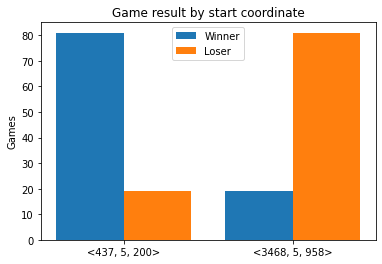

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df1 = pd.read_csv('Data/STATIC.csv', index_col=[0], sep=';')
df2 = pd.read_csv('Data/REF.csv', index_col=[0], sep=';')
frames = [df1, df2]

result = pd.concat(frames)
winSum = result.groupby('Coord')['Winner'].value_counts()
won = winSum.take([0, 3])
los = winSum.take([1, 2])

labels = result.Coord.unique() # labels of x-axis
width = 0.40  # bar width

x = np.arange(2)
fig, ax = plt.subplots() # merge two plots
ax.bar(x - width/2, won, width, label='Winner')
ax.bar(x + width/2, los, width, label='Loser')
ax.set_ylabel('Games')
ax.set_title('Game result by start coordinate')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.legend()

plt.show()

## Erste KI Evolution
Diese erste Evolution nutzt die statische KI.
Dabei werden die Parameter dieser mit einem Evolutionären Algorithmus optimiert.

| Parameter |Definitionen für EA||
| :- |:-|:-|
| Min. Leben von einer Stadt um anzugreifen |Repräsentation|Integer|
| Min./Max. Suchradius nach angreifbaren Städten |Selektion|Tunier-Selektion|
| Schrittweite beim Erweitern des Suchradius |Rekombination|arithmetischer Crossover (70%)|
||Mutation|Creep Mutation |

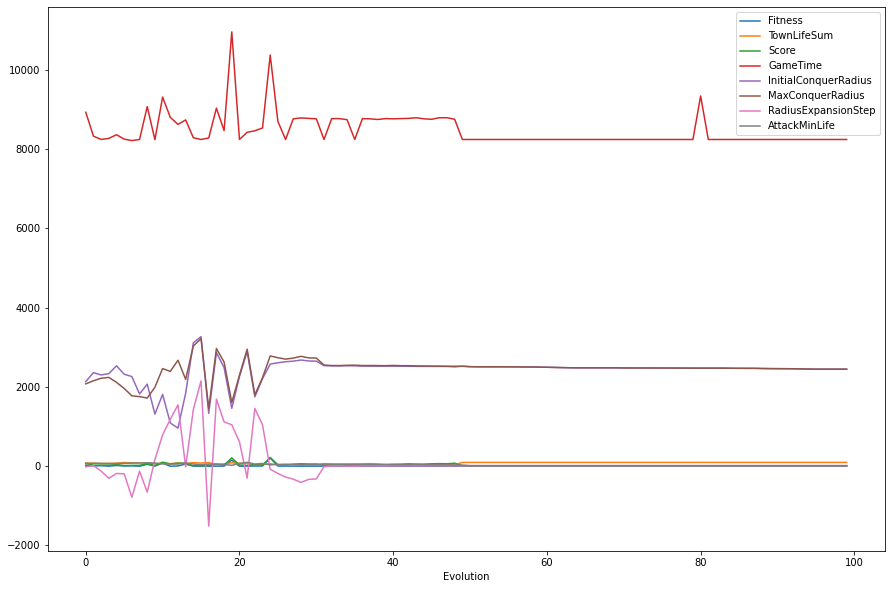

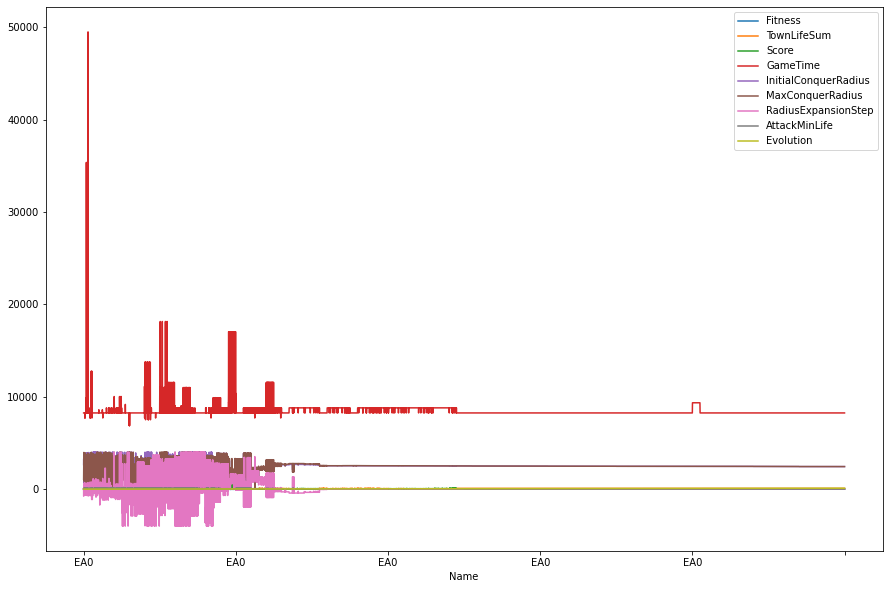

In [183]:
plt.rcParams["figure.figsize"] = (15,10)
df = pd.read_csv('Data/EA.csv', index_col=[0], sep=';')
evolutions = df.groupby(df.index).size().iloc[:1].values # get the number of evolutions
KINumer = df.groupby(df.index).size().size # get the number of different KIs (individuals)
df['Evolution'] = np.arange(evolutions).repeat(KINumer) # add new evolution column
df1 = df.reset_index().set_index(['Evolution', 'Name']) #make multiindex


dfMean = df1.groupby(level=0).agg(['mean']).stack(1) # calc mean for every evolution
dfMean = dfMean.reset_index().set_index(['Evolution']) #remove multiindex
dfMean.drop(['Winner', "level_1"], axis=1, inplace=True) # remove useless columns
dfMean.plot()
#plt.show()


#df["AttackMinLife"].plot()
#df["RadiusExpansionStep"].plot()
#df["MaxConquerRadius"].plot()
#df["InitialConquerRadius"].plot()
#df["Score"].plot()
#df["Fitness"].plot()
#df["TownLifeSum"].plot()
#df["GameTime"].plot()
df.plot()
plt.show()
